# Importing Packages

In [1]:
from pyblock2.driver.core import DMRGDriver, SymmetryTypes, MPOAlgorithmTypes
import numpy as np
import math
import matplotlib.pyplot as plt
import time

# Functions for Constructing Matrices

In [2]:
def vector_to_hermitian(upper_triangle_vector):
    # Check if the input vector is real-valued or complex-valued
    is_real = np.isrealobj(upper_triangle_vector)
    
    # Determine the size of the matrix (n x n)
    n = int(np.sqrt(2 * len(upper_triangle_vector) + 0.25) - 0.5)
    
    # Initialize an empty matrix with the appropriate type
    dtype = float if is_real else complex
    A = np.zeros((n, n), dtype=dtype)
    
    # Fill in the upper triangle
    indices = np.triu_indices(n)
    A[indices] = upper_triangle_vector
    
    # Assign values to the lower triangle
    i_lower = np.tril_indices(n, -1)
    if is_real:
        A[i_lower] = A.T[i_lower]  # Copy upper triangle values to lower triangle
    else:
        A[i_lower] = np.conj(A.T[i_lower])  # Assign conjugate transpose to lower triangle
    
    return A

# Definitions

In [4]:
params = {}
params['L'], params['N'], params['nmax'] = 64, 64, 4
params['L1'], params['L2'], params['L3'] = 30, 4, 30 
params['t'], params['U1'], params['U2'], params['U3'] = 1.0, 0.5, 10.0, 2.0

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAny, n_threads=4)

driver.set_symmetry_groups("U1")
Q = driver.bw.SX

In [7]:
# [Part A] Set states and matrix representation of operators in local Hilbert space
site_basis, site_ops = [], []

# Definig Operators
bdag = np.diag(np.sqrt(np.arange(1, params['nmax'] + 1)), k=-1) # b+
b = bdag.T # b
n = np.diag(np.arange(0, params['nmax'] + 1), k=0) # particle number 

for k in range(params['L']):
    basis = [(Q(i), 1) for i in range(params['nmax'] + 1)] 
    ops = {
        "": np.identity(params['nmax'] + 1), # identity
        "C": bdag, # b+
        "D": b,  # b
        "N": n, # particle number           
    }
    site_basis.append(basis)
    site_ops.append(ops)

# Setting Up Hamiltonian

In [8]:
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

b.add_term("CD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CD", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])

# Region 1 
b.add_term("N", np.array(np.arange(params['L1'])), -(params['U1'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L1']), 2), params['U1'] / 2)

# Region 2
b.add_term("N", np.array(np.arange(params['L2'])), -(params['U2'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L2']), 2), params['U2'] / 2)

# Region 3
b.add_term("N", np.array(np.arange(params['L3'])), -(params['U3'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L3']), 2), params['U3'] / 2)

In [9]:
# [Part C] Perform DMRG

start_time = time.time()
#########################################

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)

mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=1, occs=[1] * params['L'])
energy = driver.dmrg(
    mpo, 
    mps, 
    n_sweeps=100, 
    bond_dims=[50] * 10 + [100] * 5 + [200] * 5 + [500] * 5 + [1000] * 5, 
    noises=[1e-3] * 3 + [1e-5] * 3 + [0],  
    thrds=[1e-10] * 20, 
    dav_max_iter=100, 
    tol=1e-10, 
    iprint=1)
print("Final bond dimension =", mps.info.get_max_bond_dimension())

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")



Sweep =    0 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      0.452 | E =     -95.8333169312 | DW = 7.37023e-10

Sweep =    1 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      1.439 | E =    -100.4514831249 | DE = -4.62e+00 | DW = 2.11064e-07

Sweep =    2 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      2.674 | E =    -105.7150088374 | DE = -5.26e+00 | DW = 7.23366e-07

Sweep =    3 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      3.485 | E =    -108.0999116997 | DE = -2.38e+00 | DW = 5.79783e-07

Sweep =    4 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      4.664 | E =    -111.9204495503 | DE = -3.82e+00 | DW = 5.22325e-07

Sweep =    5 | Direction = backward 

## <font color='blue'>Evolution over sweeps</font>

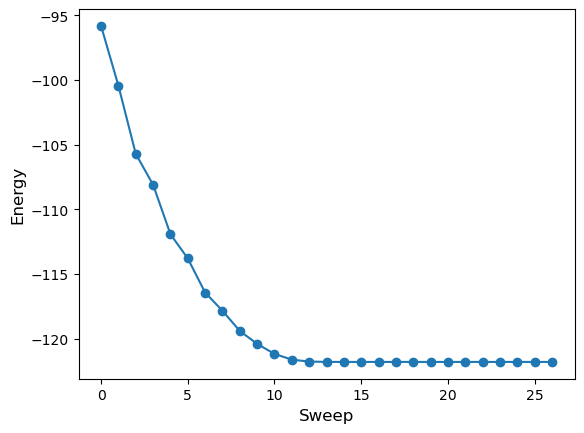

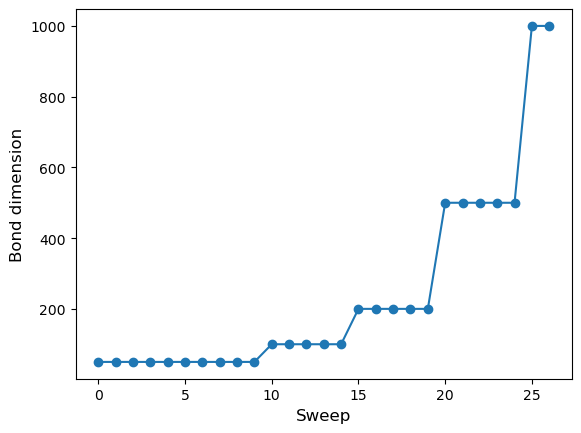

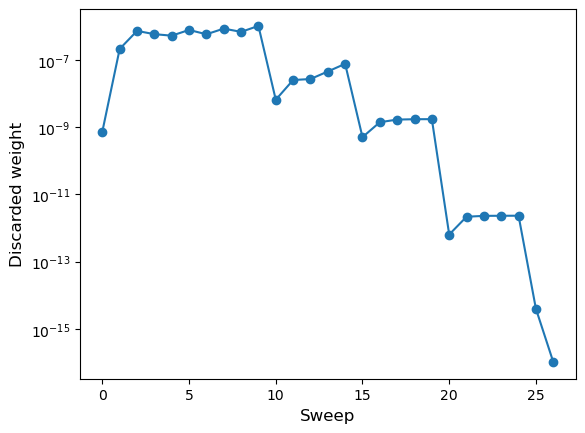

In [10]:
bonddims, discardedweights, energies = driver.get_dmrg_results()
plt.plot(energies.flatten(), marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Energy', fontsize=12)
plt.show()
plt.plot(bonddims, marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Bond dimension', fontsize=12)
plt.show()
plt.plot(discardedweights, marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Discarded weight', fontsize=12)
plt.yscale('log')
plt.show()

## <font color='blue'>Entanglement</font>

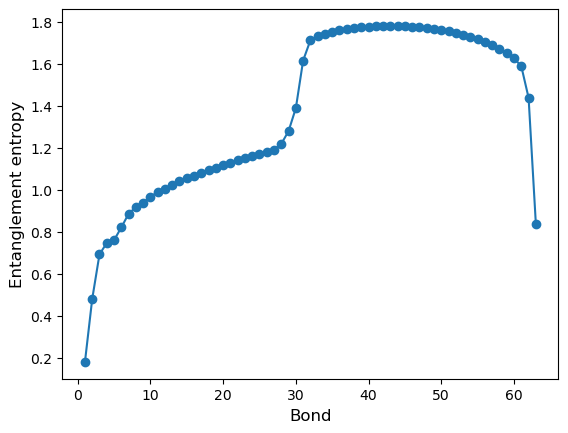

In [12]:
SvN = driver.get_bipartite_entanglement()

plt.plot(np.arange(1,params['L']), SvN, marker='o')
plt.xlabel('Bond', fontsize=12)
plt.ylabel('Entanglement entropy', fontsize=12)
plt.show()